H mult 20 E estimates: -4.8736033  -4.870925
H mult 40 E estimates: -4.906122  -4.936535
H mult 60 E estimates: -4.953764  -4.958339
H mult 80 E estimates: -4.954471  -4.969118
H mult 100 E estimates: -4.9802227  -4.975509
H mult 120 E estimates: -4.978794  -4.979719
H mult 140 E estimates: -4.9785876  -4.9826875
H mult 160 E estimates: -4.979694  -4.9848804
H mult 180 E estimates: -4.9799604  -4.986557
H mult 200 E estimates: -4.9803667  -4.987875
H mult 220 E estimates: -4.9814525  -4.9889355
H mult 240 E estimates: -4.981823  -4.989806
H mult 260 E estimates: -4.9822025  -4.990535
H mult 280 E estimates: -4.990591  -4.9911537
H mult 300 E estimates: -4.9908123  -4.9916887
H mult 320 E estimates: -4.991027  -4.9921565
H mult 340 E estimates: -4.9912343  -4.992571
H mult 360 E estimates: -4.991433  -4.9929423
H mult 380 E estimates: -4.9916234  -4.993278
H mult 400 E estimates: -4.991859  -4.9935837
H mult 420 E estimates: -4.9920354  -4.9938645
H mult 440 E estimates: -4.9922  -4.994

H mult 3560 E estimates: -4.9987707  -4.998919
H mult 3580 E estimates: -4.998774  -4.998921
H mult 3600 E estimates: -4.998778  -4.9989223
H mult 3620 E estimates: -4.998781  -4.9989243
H mult 3640 E estimates: -4.9987845  -4.9989257
H mult 3660 E estimates: -4.9987884  -4.9989276
H mult 3680 E estimates: -4.9987917  -4.998929
H mult 3700 E estimates: -4.998795  -4.998931
H mult 3720 E estimates: -4.9987984  -4.9989324
H mult 3740 E estimates: -4.9988017  -4.9989343
H mult 3760 E estimates: -4.998805  -4.9989357
H mult 3780 E estimates: -4.9988084  -4.998937
H mult 3800 E estimates: -4.9988117  -4.998939
H mult 3820 E estimates: -4.998815  -4.9989405
H mult 3840 E estimates: -4.9988184  -4.998942
H mult 3860 E estimates: -4.9988213  -4.9989433
H mult 3880 E estimates: -4.9988246  -4.9989448
H mult 3900 E estimates: -4.998834  -4.9989467
H mult 3920 E estimates: -4.998837  -4.998948
H mult 3940 E estimates: -4.9988403  -4.9989495
H mult 3960 E estimates: -4.998843  -4.998951
H mult 398

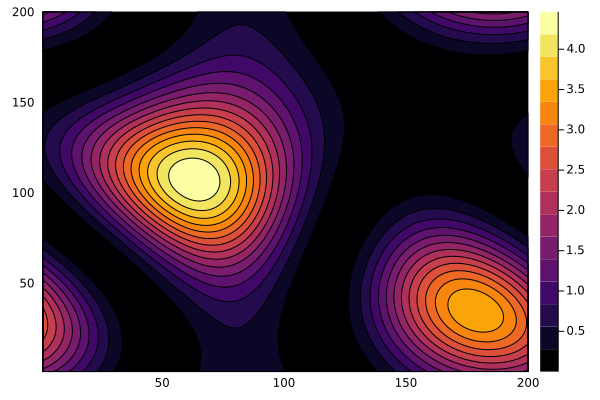

In [6]:
# Demonstration of the H-power (ground state projection) and
# Lanczos methods, using the 2D Anderson Localization model
# - a particle on an L*L lattice with random potentials.

 using Plots
 using LinearAlgebra

# Constructs random potential in a vector of size nn=ll*ll
# - v0 is the overall scale of uniformly distributed values
# - v0 should be positive to ensure ground state has the
#   lowest |E|. A negative offset (-1) also helps here.

  function randompotential(nn::Int,v0::Float64)
    rpot=Vector{Float64}(undef,nn)
    for i=1:nn
        rpot[i]=v0*(rand()-1.)-1.
    end
    return rpot
 end

# Creates a random initial state vector

 function randomstate(nn::Int)
    rvec=Vector{Float64}(undef,nn)
    for i=1:nn
       rvec[i]=rand()-0.5
    end
    rvec.=rvec./dot(rvec,rvec)^0.5
    return rvec
 end

# For a 2D lattice of size ll*ll, operates with the Hamiltonian (including the 
# random potential energy stored in the vecor vv) on the vector f1, resulting in f2.
# If nor==1, the state f2 is normalized and two energy estimates are returned.
# - r is the ratio of two large wave function coefficients
# - e is the expectation value <f1|H|f1> 

function hoperation(ll::Int,vv,nor,f1,f2)
   f2.=vv.*f1
   for y0=0:ll-1
      for x0=0:ll-1
         j0=1+x0+y0*ll
         x1::Int=mod(x0-1,ll)
         x2::Int=mod(x0+1,ll)
         y1::Int=mod(y0-1,ll)
         y2::Int=mod(y0+1,ll)
         f2[1+x1+y0*ll] -= f1[j0]
         f2[1+x2+y0*ll] -= f1[j0]
         f2[1+x0+y1*ll] -= f1[j0]
         f2[1+x0+y2*ll] -= f1[j0]
       end
    end
    if nor==1
       mv,mi=findmax(abs.(f1))   # Julia base function, value and index of max
       r::Float64=f2[mi]/f1[mi]  # This ratio should converge to the max (abs) eigenvalue
       e::Float64=dot(f1,f2)     # This is the expectation value <f1|H|f1>
       f2.=f2./dot(f2,f2)^0.5    # Now normalize |f2> = H|f1>    
       return r,e        
    else
       return nothing
    end        
 end

# Makes a 2D color-contour plot of the wave function psi
# Returns the plot as p, which can be displayed later

function plotstate(ll::Int,psi)
    x=zeros(Int,ll)
    y=zeros(Int,ll)
    z=zeros(Float64,ll,ll)
    for j=1:ll
       x[j]=j
       y[j]=j
       for i=1:ll
          z[i,j]=(ll^2)*psi[i+(j-1)*ll]^2
       end
    end
    p=contour(x,y,z,fill=true)
    return p
 end

# Performs nit Lanczos iterations, starting from f0.
# The method with normalized states is used.
# Note that the elements in aa[:] and nn[:] start at 1,
# so are shifted by one step relative to the notation used
# in the lectures. After each 10 iterations, the tridiagonal
# H matrix is constructed and its eigenvalues are calculated
# and shown, to check the convergence.

 function lanczos(nit::Int,ll::Int,vv,f0)
    f1=copy(f0)
    f2=copy(f1)
    aa=zeros(Float64,nit)
    nn=zeros(Float64,nit+1)
    nn[1]=1
    hoperation(ll,vv,0,f0,f1)
    aa[1]=dot(f0,f1)
    f1.=f1.-aa[1].*f0
    nn[2]=dot(f1,f1)^0.5
    f1.=f1./nn[2]
    for m=2:nit
       hoperation(ll,vv,0,f1,f2)
       aa[m]=dot(f1,f2)
       f2.=f2.-aa[m].*f1-nn[m]*f0
       nn[m+1]=dot(f2,f2)^0.5
       f2.=f2./nn[m+1]
       f0.=f1
       f1.=f2
       if mod(m,10)==0
          mat=zeros(Float64,m,m)
          for i=1:m
             mat[i,i]=aa[i]
             if i>1
                mat[i-1,i]=nn[i]
             end
             if i<m
                mat[i+1,i]=nn[i+1]
             end
          end
          eig=eigvals(mat)
          e0=convert(Float32,eig[1]) # for less output digits
          println("Lanczos iteration ",m," E0 = ",e0)
       end
    end
 end

# Projecting out the ground state by successively acting
# with H on the initial state f0. Displays the two energy
# estimates delivered by hoperation() every 20th step.

 function gsprojection(nit,ll,vv,f0)
    f1=copy(f0)
    for i=1:nit
      ee0,ee1=hoperation(ll,vv,1,f0,f1)
      f0.=f1
      if mod(i,20)==0
         e0=convert(Float32,ee0) # Converting just to have less 
         e1=convert(Float32,ee1) # output digits (prmitive way)
         println("H mult ",i," E estimates: ",e0,"  ",e1)
      end    
    end  
    return plotstate(ll,f1)
 end

 v0=0.0001    # strength of the random potential (>0)
 ll=200       # length of the periodic ll*ll lattice
 nn=ll*ll     # The number of lattice sites
 nit1=5000    # Number of iterations for ground state projection
 nit2=200     # Number of iterations in the Lanczos calculation

 vv=randompotential(nn,v0)
 psi=randomstate(nn)
 f0=copy(psi)

 p=gsprojection(nit1,ll,vv,f0)
 println()

 f0.=psi
 lanczos(nit2,ll,vv,f0)

 println()
 println("Graphing final psi^2 (times ll^2) from gsprojection")
 plot(p)
